# 株価予測

- [超簡単Pythonで株価予測（LightGBM 利用）機械学習](https://note.com/10mohi6/n/n4b1196fea816)
- [超簡単Pythonで株価予測（Optuna・LightGBM 利用）ハイパーパラメータ自動最適化](https://note.com/10mohi6/n/n46d1bb0267b7)

In [1]:
!pip install scikit-learn lightgbm pandas-datareader optuna

In [2]:
import pandas_datareader as pdr
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score

df = pdr.get_data_yahoo("AAPL", "2010-11-01", "2020-11-01")
df["Diff"] = df.Close.diff()
df["SMA_2"] = df.Close.rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]
df["y"] = df["Diff"].apply(lambda x: 1 if x > 0 else 0).shift(-1)
df = df.drop(
  ["Open", "High", "Low", "Close", "Volume", "Diff", "Adj Close"],
  axis=1,
).dropna()
# print(df)
X = df.drop(["y"], axis=1).values
y = df["y"].values
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.2,
  shuffle=False,
)
clf = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=20)
clf.fit(
  X_train,
  y_train,
)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred > 0.5))
print(f1_score(y_test, y_pred > 0.5, average='macro'))

0.5456349206349206
0.3893042525834564


In [3]:
import pandas_datareader as pdr
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import optuna

def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        shuffle=False,
    )
    dtrain = lgb.Dataset(X_train, label=y_train)
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

df = pdr.get_data_yahoo("AAPL", "2010-11-01", "2020-11-01")
df["Diff"] = df.Close.diff()
df["SMA_2"] = df.Close.rolling(2).mean()
df["Force_Index"] = df["Close"] * df["Volume"]
df["y"] = df["Diff"].apply(lambda x: 1 if x > 0 else 0).shift(-1)
df = df.drop(
    ["Open", "High", "Low", "Close", "Volume", "Diff", "Adj Close"],
    axis=1,
).dropna()
# print(df)
X = df.drop(["y"], axis=1).values
y = df["y"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=False,
)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
trial = study.best_trial
clf = lgb.LGBMRegressor(**dict(trial.params.items()))
clf.fit(
    X_train,
    y_train,
)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred > 0.5))
print(f1_score(y_test, y_pred > 0.5, average='macro'))

[I 2022-02-05 16:31:33,361] A new study created in memory with name: no-name-9b5c2387-367d-4d29-ac25-45710893a108
[I 2022-02-05 16:31:33,377] Trial 0 finished with value: 0.4642857142857143 and parameters: {'lambda_l1': 0.11948047820511622, 'lambda_l2': 1.3201813674162582e-06, 'num_leaves': 5, 'feature_fraction': 0.6567768558463127, 'bagging_fraction': 0.5888576935616987, 'bagging_freq': 4, 'min_child_samples': 90}. Best is trial 0 with value: 0.4642857142857143.
[I 2022-02-05 16:31:33,408] Trial 1 finished with value: 0.5376984126984127 and parameters: {'lambda_l1': 5.253217504187064, 'lambda_l2': 0.5493360398760493, 'num_leaves': 113, 'feature_fraction': 0.6395952309037455, 'bagging_fraction': 0.8615137840708028, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 1 with value: 0.5376984126984127.
[I 2022-02-05 16:31:33,426] Trial 2 finished with value: 0.4742063492063492 and parameters: {'lambda_l1': 0.002645965524485821, 'lambda_l2': 1.1654453297315245e-07, 'num_leaves': 99,

[LightGBM] [Warning] lambda_l1 is set=0.3250848594027112, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3250848594027112
[LightGBM] [Warning] feature_fraction is set=0.7788188766411459, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7788188766411459
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.308826632967308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.308826632967308
[LightGBM] [Warning] bagging_fraction is set=0.4632299139620134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4632299139620134
0.5436507936507936
0.47693307342430147


In [4]:
#import codecs
#import numpy as np
from matplotlib import pyplot as plt
#import pandas as pd
from sklearn import metrics
#import optuna.integration.lightgbm as lgb

AUC 0.5163409087294645


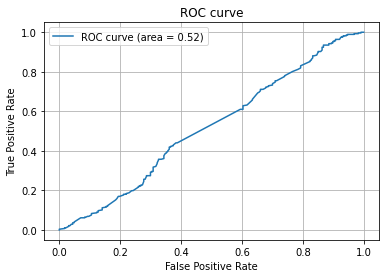

accuracy 0.5436507936507936
precision 0.5577395577395577


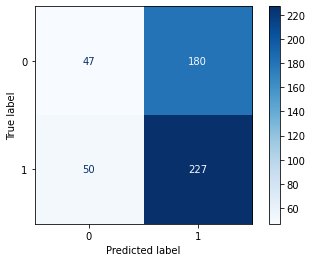

In [5]:
# AUCを計算
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC", auc)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# accuracy, precisionを計算
acc = metrics.accuracy_score(np.asarray(y_test), np.round(y_pred))
precision = metrics.precision_score(np.asarray(y_test), np.round(y_pred))
print("accuracy", acc)
print("precision", precision)

# 混同行列をプロット
y_pred = np.round(y_pred)
cm = metrics.confusion_matrix(np.asarray(y_test), np.where(y_pred < 0.5, 0, 1))
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmp.plot(cmap=plt.cm.Blues)
plt.show()